## Molecular Property Prediction

Molecular property prediction plays a crucial role in drug discovery by enabling the estimation of key characteristics, such as solubility, permeability, and bioavailability, without extensive experimental efforts. These predictions help prioritize compounds for synthesis and testing, saving time and resources.

This project utilizes the following tools:
- **RDKit**: A cheminformatics library for handling chemical information and generating molecular descriptors.
- **Mordred**: A Python library for calculating thousands of molecular descriptors from chemical structures.

#### Objectives of this Project:
- Predict aqueous solubility (logS) values of small drug-like molecules.
- Build a regression model using experimental data and molecular descriptors.
- Visualize relationships between descriptors and solubility values.

In [1]:
%pip install requests
%pip install pandas
%pip install mordred
%pip install statsmodels
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import requests
import time

### Aqueous solubility (logS)

Aqueous solubility (logS) is a critical molecular property in drug discovery as it directly impacts a compound's absorption, distribution, and overall bioavailability. Poor solubility is a major reason why many promising drug candidates fail during development.

The experimental logS values for this project were sourced from:  
[**The AAPS Journal 2005; 7 (1) Article 10**](https://link.springer.com/article/10.1208/aapsj070110)
  
This dataset provides high-quality solubility data for drug-like organic compounds under standardized conditions.


In [2]:
df = pd.read_csv('logS_dataset.csv', sep=';') 
df.head(5)  

,Name,logS
0,"1,2,3-Trichlorobenzene",–3.76
1,"1,3,5-Trichlorobenzene",–4.44
2,"1,4-Dibromobenzene",–4.07
3,17Alpha-ethynylestradiol,–4.484
4,1-Butyltheobromine,–1.625


### Retrieving Canonical SMILES from PubChem

Canonical SMILES for the compounds in the dataset were retrieved using the PubChem PUG REST API. According to PubChem's usage policies:
- The request rate must be limited to **five requests per second** or fewer to avoid being temporarily blocked from accessing PubChem (or NCBI) resources.
- Each request has a standard time limit of **30 seconds**, after which a time-out error will occur if the request is not completed.

To comply with these policies, requests were processed in a controlled manner with a delay between queries.

In [4]:
prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'
name_list = df['Name'].values.tolist()

smiles = []

def get_smiles(start, end): # start and end index of a batch
    
    smiles_batch = []
    idx = 0
    for name in name_list[start:end]: # loop over each element in the batch 

        url = prolog + '/compound/name/' + name + '/property/CanonicalSMILES/txt'
        res = requests.get(url)

        if res.status_code == 200:
            smiles_batch += list(set(res.text.split())) # Use a set to remove duplicates (w/ different CIDs)
        else:
            smiles_batch.append('None')
        
        if idx % 5 == 4: # to limit the request rate to five requests per second
            time.sleep(0.2)
        idx += 1
    
    return smiles_batch

In [5]:
num_batch = len(name_list) // 50 # Batch size of 50 compounds

for i in range(num_batch): # loop over each batch in the 'name_list' list
    start = i*50
    end = (i+1)*50
    smiles += get_smiles(start, end)
    print(f'Compounds {start+1} - {end} Done!')
    time.sleep(1)

last_batch_start = 50*num_batch
last_batch_end = 50*num_batch + len(name_list)%50
smiles += get_smiles(last_batch_start, last_batch_end)
print(f'Compounds {last_batch_start+1} - {last_batch_end} Done!')

print(len(smiles))

Compounds 1 - 50 Done!
Compounds 51 - 100 Done!
Compounds 101 - 150 Done!
Compounds 151 - 200 Done!
Compounds 201 - 250 Done!
Compounds 251 - 300 Done!
Compounds 301 - 322 Done!
322


The retrieved Canonical SMILES were added as a new column to the dataset. This ensures that molecular structures are readily accessible for further descriptor calculations and analysis.

In [6]:
df['Canonical_SMILES'] = smiles
df

,Name,logS,Canonical_SMILES
0,"1,2,3-Trichlorobenzene",–3.76,C1=CC(=C(C(=C1)Cl)Cl)Cl
1,"1,3,5-Trichlorobenzene",–4.44,C1=C(C=C(C=C1Cl)Cl)Cl
2,"1,4-Dibromobenzene",–4.07,C1=CC(=CC=C1Br)Br
3,17Alpha-ethynylestradiol,–4.484,CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O
4,1-Butyltheobromine,–1.625,CCCCN1C(=O)C2=C(N=CN2C)N(C1=O)C
...,...,...,...
317,Uric acid,–3.402,C12=C(NC(=O)N1)NC(=O)NC2=O
318,Vinbarbital,–2.458,CCC=C(C)C1(C(=O)NC(=O)NC1=O)CC
319,Xanthine,–2.483,C1=NC2=C(N1)C(=O)NC(=O)N2
320,Zidovudine,–1.029,CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)N=[N+]=[N-]


### Data Cleaning: Handling Missing and Invalid Values

Several compounds are not found in the PubChem queries. These missing Canonical SMILES are manually searched and added to the dataset. After updating the dataset with the manually collected SMILES, the dataframe is checked for any remaining missing values. 

In [7]:
indices = [i for i, val in enumerate(smiles) if val == 'None']

name_not_found = []
for i in indices:
    name_not_found.append(df['Name'].iloc[i])

print(len(indices))
print(name_not_found)

30
['1-Propyltheobromine', '2-Aminopteridine', '2-Hydroxypteridine', '5,5-Diethylbarbiturate', '5,5-Dimethylbarbiturate', '5,5-Diphenylbarbiturate', '5,5-Dipropylbarbiturate', '5-Allyl-5-phenylbarbiturate', '5-Ethyl-5-(3-methylbut-2-enyl)barbiturate', '5-Ethyl-5-allylbarbiturate', '5-Ethyl-5-nonylbarbiturate', '5-Ethyl-5-octylbarbiturate', '5-Ethyl-5-pentylbarbiturate', '5-Ethyl-5-propylbarbiturate', '5-Ethyl-barbiturate', '5-i-Propyl-5-(3-methylbut-2enyl)barbiturate', '5-Methyl barbiturate', '5-Methyl-5-(3-methylbut-2enyl)barbiturate', '5-Methyl-5-ethylbarbiturate', '5-t-Butyl-5-(3-methylbut-2enyl)barbiturate', 'Cyclobutane-spirobarbiturate', 'Cycloethane-spirobarbiturate', 'Cycloheptane-spirobarbiturate', 'Cyclohexane-spirobarbiturate', 'Cyclopentane-spirobarbiturate', 'Cyclopropane-spirobarbiturate', 'Isopropylbarbiturate', 'Pteridine-2-methyl-thiol', 'Pteridine-4-methyl-thiol', 'Pteridine-7-methyl-thiol']


In [8]:
smiles_missing = {'1-Propyltheobromine': 'CCCN1C(=O)C2=C(N=CN2C)N(C1=O)C',
                  '2-Aminopteridine': 'N=1C=CN=C2C=NC(=NC12)N',
                  '2-Hydroxypteridine': 'O=C1N=CN=C2NC=CN=C12',
                  '5,5-Diethylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CC',
                  '5,5-Dimethylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(C)C',
                  '5,5-Diphenylbarbiturate': 'O=C1NC(=O)C(C=2C=CC=CC2)(C=3C=CC=CC3)C(=O)N1',
                  '5,5-Dipropylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CCC)CCC',
                  '5-Allyl-5-phenylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(C=2C=CC=CC2)CC=C',
                  '5-Ethyl-5-(3-methylbut-2-enyl)barbiturate': 'O=C1NC(=O)C(C=CC(C)C)(C(=O)N1)CC',
                  '5-Ethyl-5-allylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC=C)CC',
                  '5-Ethyl-5-nonylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCCCCCCCC',
                  '5-Ethyl-5-octylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCCCCCCC',
                  '5-Ethyl-5-pentylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCCCC',
                  '5-Ethyl-5-propylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCC',
                  '5-Ethyl-barbiturate': 'O=C1NC(=O)C(C(=O)N1)CC',
                  '5-i-Propyl-5-(3-methylbut-2enyl)barbiturate': 'O=C1NC(=O)C(C=CC(C)C)(C(=O)N1)C(C)C',
                  '5-Methyl barbiturate': 'O=C1NC(=O)C(C(=O)N1)C',
                  '5-Methyl-5-(3-methylbut-2enyl)barbiturate': 'O=C1NC(=O)C(C=CC(C)C)(C(=O)N1)C',
                  '5-Methyl-5-ethylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(C)CC',
                  '5-t-Butyl-5-(3-methylbut-2enyl)barbiturate': 'O=C1N(C(=O)C(C=CC(C)C)(C(=O)N1)C(C)(C)C)',
                  'Cyclobutane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCC2',
                  'Cycloethane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CC2',
                  'Cycloheptane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCCCCC2',
                  'Cyclohexane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCCCC2',
                  'Cyclopentane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCCC2',
                  'Cyclopropane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCC2',
                  'Isopropylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)C(C)C',
                  'Pteridine-2-methyl-thiol': 'N=1C=CN=C2C=NC(=NC12)SC',
                  'Pteridine-4-methyl-thiol': 'N=1C=NC(SC)=C2N=CC=NC12',
                  'Pteridine-7-methyl-thiol': 'N=1C=NC=2N=C(SC)C=NC2C1'
                  }

In [9]:
for name, smiles in smiles_missing.items():
    df.loc[(df["Name"] == name) & (df["Canonical_SMILES"] == "None"), "Canonical_SMILES"] = smiles

print(df[df['Canonical_SMILES'] == 'None']) # Check if there are still missing SMILES

Empty DataFrame
Columns: [Name, logS, Canonical_SMILES]
Index: []


During the processing of Canonical SMILES, some compounds had invalid SMILES strings, which caused errors during molecule generation in RDKit (e.g., explicit valence errors). To ensure the integrity of the dataset, compounds with invalid SMILES were identified and dropped from the dataframe. This step was crucial for avoiding errors in subsequent descriptor calculations and model building.


In [75]:
from rdkit import Chem

invalid_indices = [i for i, val in enumerate(df["Canonical_SMILES"]) if Chem.MolFromSmiles(val) == None]

print(invalid_indices)

[8, 45, 51]


[17:45:59] Explicit valence for atom # 8 Cl, 3, is greater than permitted
[17:45:59] Explicit valence for atom # 8 Cl, 3, is greater than permitted
[17:45:59] Explicit valence for atom # 7 Cl, 3, is greater than permitted


In [76]:
df_updated = df.drop(df.index[invalid_indices])
still_invalid = [i for i, val in enumerate(df_updated["Canonical_SMILES"]) if Chem.MolFromSmiles(val) == None]

print(still_invalid)

[]


The logS values were initially stored as strings, which needed to be converted to floats for numerical analysis and modeling. Also, the negative signs of logS values were written with en dashes (–) instead of hyphens (-), which can cause issues during processing. These were replaced with standard hyphens to ensure compatibility with cheminformatics tools.

In [77]:
df = df_updated
df['logS'] = df['logS'].str.replace('–', '-').astype(float)

The final updated dataframe, now complete with Canonical SMILES, is saved as a CSV file for further use in the project.

In [78]:
df.to_csv('logS_dataset_updated.csv', index=False)

In [32]:
df = pd.read_csv('logS_dataset_updated.csv', sep=',') 

### Finding the Best Descriptors

To predict aqueous solubility (logS), we calculate a wide range of molecular descriptors that capture key properties. Identifying the most relevant descriptors helps build a focused and interpretable regression model while eliminating irrelevant features.

Mordred descriptors were calculated for all molecules in the dataset using their Canonical SMILES. 

In [33]:
from mordred import Calculator, descriptors
from rdkit import Chem

smiles_list = df['Canonical_SMILES']

calc = Calculator(descriptors, ignore_3D=True)  # 2D descriptors only
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
desc_df = calc.pandas(molecules)

print(desc_df)

                                                   ABC  \
0    module 'numpy' has no attribute 'float'.\n`np....   
1    module 'numpy' has no attribute 'float'.\n`np....   
2    module 'numpy' has no attribute 'float'.\n`np....   
3    module 'numpy' has no attribute 'float'.\n`np....   
4    module 'numpy' has no attribute 'float'.\n`np....   
..                                                 ...   
314  module 'numpy' has no attribute 'float'.\n`np....   
315  module 'numpy' has no attribute 'float'.\n`np....   
316  module 'numpy' has no attribute 'float'.\n`np....   
317  module 'numpy' has no attribute 'float'.\n`np....   
318  module 'numpy' has no attribute 'float'.\n`np....   

                                                 ABCGG  nAcid  nBase  \
0    module 'numpy' has no attribute 'float'.\n`np....      0      0   
1    module 'numpy' has no attribute 'float'.\n`np....      0      0   
2    module 'numpy' has no attribute 'float'.\n`np....      0      0   
3    module 'nu

Some Mordred descriptors produced non-float values, which caused errors during processing. 
To resolve this, only descriptors with data type `float` were retained.

In [34]:
desc_df_cleaned = desc_df.select_dtypes(include=['float'])

print(f"Original shape: {desc_df.shape}")
print(f"Cleaned shape: {desc_df_cleaned.shape}")

Original shape: (319, 1613)
Cleaned shape: (319, 905)


To further clean the dataset:
1. **Drop Columns and Rows with All NaN Values:** Columns and rows where all values were `NaN` were removed.
2. **Optional: Drop Columns with Partial NaN Values:** Columns with any `NaN` values were also dropped to ensure all descriptors are fully usable.
3. **Remove Zero-Variance Descriptors:** Columns where all values were constant (e.g., all zeros) were dropped, as they do not provide useful information for the model.

This step ensures that the final dataset contains only meaningful and complete descriptors.

In [36]:
# Drop columns and rows with all NaN values
desc_df_cleaned = desc_df_cleaned.dropna(axis=1, how='all')
desc_df_cleaned = desc_df_cleaned.dropna(axis=0, how='all')

# Drop columns with partial NaN values (optional)
desc_df_cleaned = desc_df_cleaned.dropna(axis=1, how='any')

all_zero_columns = desc_df_cleaned.columns[(desc_df_cleaned == 0).all()]
desc_df_cleaned = desc_df_cleaned.drop(columns=all_zero_columns)

In [37]:
desc_df_cleaned.to_csv('desc_df_cleaned.csv', index=False)

In [3]:
df = pd.read_csv('logS_dataset_updated.csv', sep=',') 
desc_df_cleaned = pd.read_csv('desc_df_cleaned.csv', sep=',') 

Correlations between the cleaned descriptors and the target property (logS) were calculated. The top 20 descriptors with the highest correlations were selected as the most relevant features for the predictive model.

In [39]:
correlations = desc_df_cleaned.corrwith(df['logS']).abs().sort_values(ascending=False)

top_descriptors = correlations.head(20).index.tolist()
selected_data = desc_df_cleaned[top_descriptors]

print(top_descriptors)

['SLogP', 'FilterItLogS', 'Mi', 'AATS0i', 'AATS4i', 'AATS2i', 'AATS1i', 'ZMIC1', 'ETA_dPsi_A', 'AATS3i', 'AMID_C', 'BCUTm-1l', 'PEOE_VSA6', 'ETA_psi_1', 'BCUTZ-1l', 'BCUTpe-1l', 'BCUTse-1l', 'GATS1i', 'BCUTare-1l', 'AATS1p']


In [40]:
top_descriptors.remove('SLogP')
top_descriptors.remove('FilterItLogS')
print(top_descriptors)

['Mi', 'AATS0i', 'AATS4i', 'AATS2i', 'AATS1i', 'ZMIC1', 'ETA_dPsi_A', 'AATS3i', 'AMID_C', 'BCUTm-1l', 'PEOE_VSA6', 'ETA_psi_1', 'BCUTZ-1l', 'BCUTpe-1l', 'BCUTse-1l', 'GATS1i', 'BCUTare-1l', 'AATS1p']


In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
X = desc_df_cleaned[top_descriptors]  
X = X.assign(Intercept=1)  
vif = pd.DataFrame({
    'Descriptor': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)

    Descriptor           VIF
0           Mi  1.022089e+03
1       AATS0i  9.688780e+02
2       AATS4i  5.567422e+00
3       AATS2i  3.560338e+01
4       AATS1i  2.274331e+01
5        ZMIC1  3.274382e+00
6   ETA_dPsi_A  4.778002e+01
7       AATS3i  4.565133e+00
8       AMID_C  4.990793e+01
9     BCUTm-1l  3.391198e+03
10   PEOE_VSA6  2.995728e+00
11   ETA_psi_1  2.184587e+01
12    BCUTZ-1l  6.391352e+03
13   BCUTpe-1l  3.476110e+02
14   BCUTse-1l  9.812483e+02
15      GATS1i  1.666602e+01
16  BCUTare-1l  1.635151e+02
17      AATS1p  1.985054e+01
18   Intercept  3.210747e+07


In [44]:
desc_indices = [i for i, val in enumerate(vif['VIF']) if val < 10]
top_desc_updated = [top_descriptors[i] for i in desc_indices]
print(top_desc_updated)

['AATS4i', 'ZMIC1', 'AATS3i', 'PEOE_VSA6']


In [65]:
from sklearn.model_selection import train_test_split

X = desc_df_cleaned[top_desc_updated]
y = df['logS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   logS   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     66.34
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           3.51e-38
Time:                        15:13:55   Log-Likelihood:                -402.51
No. Observations:                 255   AIC:                             815.0
Df Residuals:                     250   BIC:                             832.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.1920      2.650     -5.734      0.0

In [47]:
X_test = sm.add_constant(X_test)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R-squared: {r2}")

Test MSE: 1.5258735801605583
Test R-squared: 0.4165563560072776


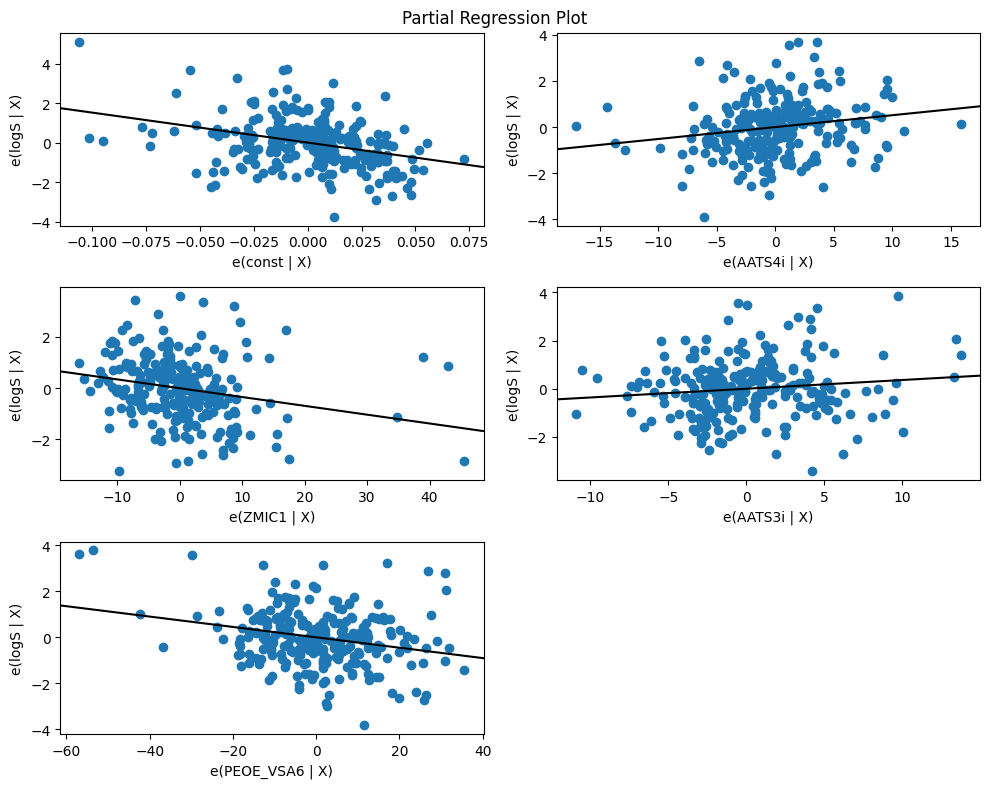

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train = X_train.drop(columns=['const'], errors='ignore')
X_test = X_test.drop(columns=['const'], errors='ignore')

assert list(X_train.columns) == list(X_test.columns), "Feature mismatch between training and test data"

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R-squared: {r2_rf}")

Random Forest MSE: 1.3175756645981331
Random Forest R-squared: 0.49620259700126723


In [86]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR MSE: {mse_svr}")
print(f"SVR R-squared: {r2_svr}")

SVR MSE: 1.4885201135604553
SVR R-squared: 0.4308390875207436


In [80]:
from mordred import WienerIndex
from rdkit import Chem

wiener_index = WienerIndex.WienerIndex()
result_wiener = []

for index, row in df.iterrows():                
    smile = row['Canonical_SMILES']                       
    mol = Chem.MolFromSmiles(smile)             
    result_wiener.append(wiener_index(mol)) 

df_new = df
df_new['WienerIndex'] = result_wiener 

df_new

,Name,logS,Canonical_SMILES,WienerIndex
0,"1,2,3-Trichlorobenzene",-3.760,C1=CC(=C(C(=C1)Cl)Cl)Cl,82
1,"1,3,5-Trichlorobenzene",-4.440,C1=C(C=C(C=C1Cl)Cl)Cl,84
2,"1,4-Dibromobenzene",-4.070,C1=CC(=CC=C1Br)Br,62
3,17Alpha-ethynylestradiol,-4.484,CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O,941
4,1-Butyltheobromine,-1.625,CCCCN1C(=O)C2=C(N=CN2C)N(C1=O)C,478
...,...,...,...,...
314,Uric acid,-3.402,C12=C(NC(=O)N1)NC(=O)NC2=O,178
315,Vinbarbital,-2.458,CCC=C(C)C1(C(=O)NC(=O)NC1=O)CC,398
316,Xanthine,-2.483,C1=NC2=C(N1)C(=O)NC(=O)N2,138
317,Zidovudine,-1.029,CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)N=[N+]=[N-],701


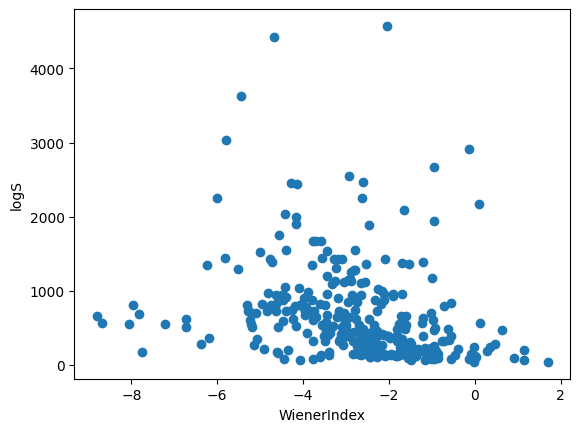

In [81]:
import matplotlib.pyplot as plt

plt.scatter(df['logS'], df_new.WienerIndex) 
plt.xlabel('WienerIndex')
plt.ylabel('logS')
plt.show()